Mounted at /content/drive
✅ Google Drive mounted successfully!

📥 Downloading COCO 2017 dataset (this takes ~5-10 mins)...
📦 Extracting files...
✅ Dataset ready!

✅ TensorFlow Version: 2.19.0

PREPROCESSING 2000 IMAGES
loading annotations into memory...
Done (t=16.62s)
creating index...
index created!


Processing: 100%|██████████| 2000/2000 [00:26<00:00, 74.98it/s]


✅ Saved 1979 images

✅ Found 1979 images


Loading data: 100%|██████████| 1979/1979 [00:02<00:00, 918.92it/s]


✅ Train: 1583, Val: 396

BUILDING MOBILENET U-NET
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
✅ Model ready!

TRAINING - 3 EPOCHS

Epoch 1/3
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7060 - loss: 0.7282 - mean_io_u: 0.3589
Epoch 1: val_loss improved from inf to 0.40374, saving model to /content/drive/MyDrive/segmentation_results/best_model.keras
99/99 ━━━━━━━━━━━━━━━━━━━━ 253s 2s/step - accuracy: 0.7065 - loss: 0.7264 - mean_io_u: 0.3589 - val_accuracy: 0.8185 - val_loss: 0.4037 - val_mean_io_u: 0.3496 - learning_rate: 0.0010
Epoch 2/3
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8211 - loss: 0.3909 - mean_io_u: 0.3566
Epoch 2: val_loss improved from 0.40374 to 0.38526, saving model to /content/drive/MyDrive/segmentation_results/best_model.keras
99/99 ━━━━━━━━━━━━━━━━━━━━ 244s 2s/step - accuracy: 0.8211 - loss: 0.3908 - mean_io_u: 0.3567 - val_accuracy: 0.8241 - val_loss: 0.3853 - val_mean_io_u: 0.3496 - learning_rate: 0.0010
Epoch 3/3
99/99 ━━━━━━━━━━━━━━━━━━━━ 0

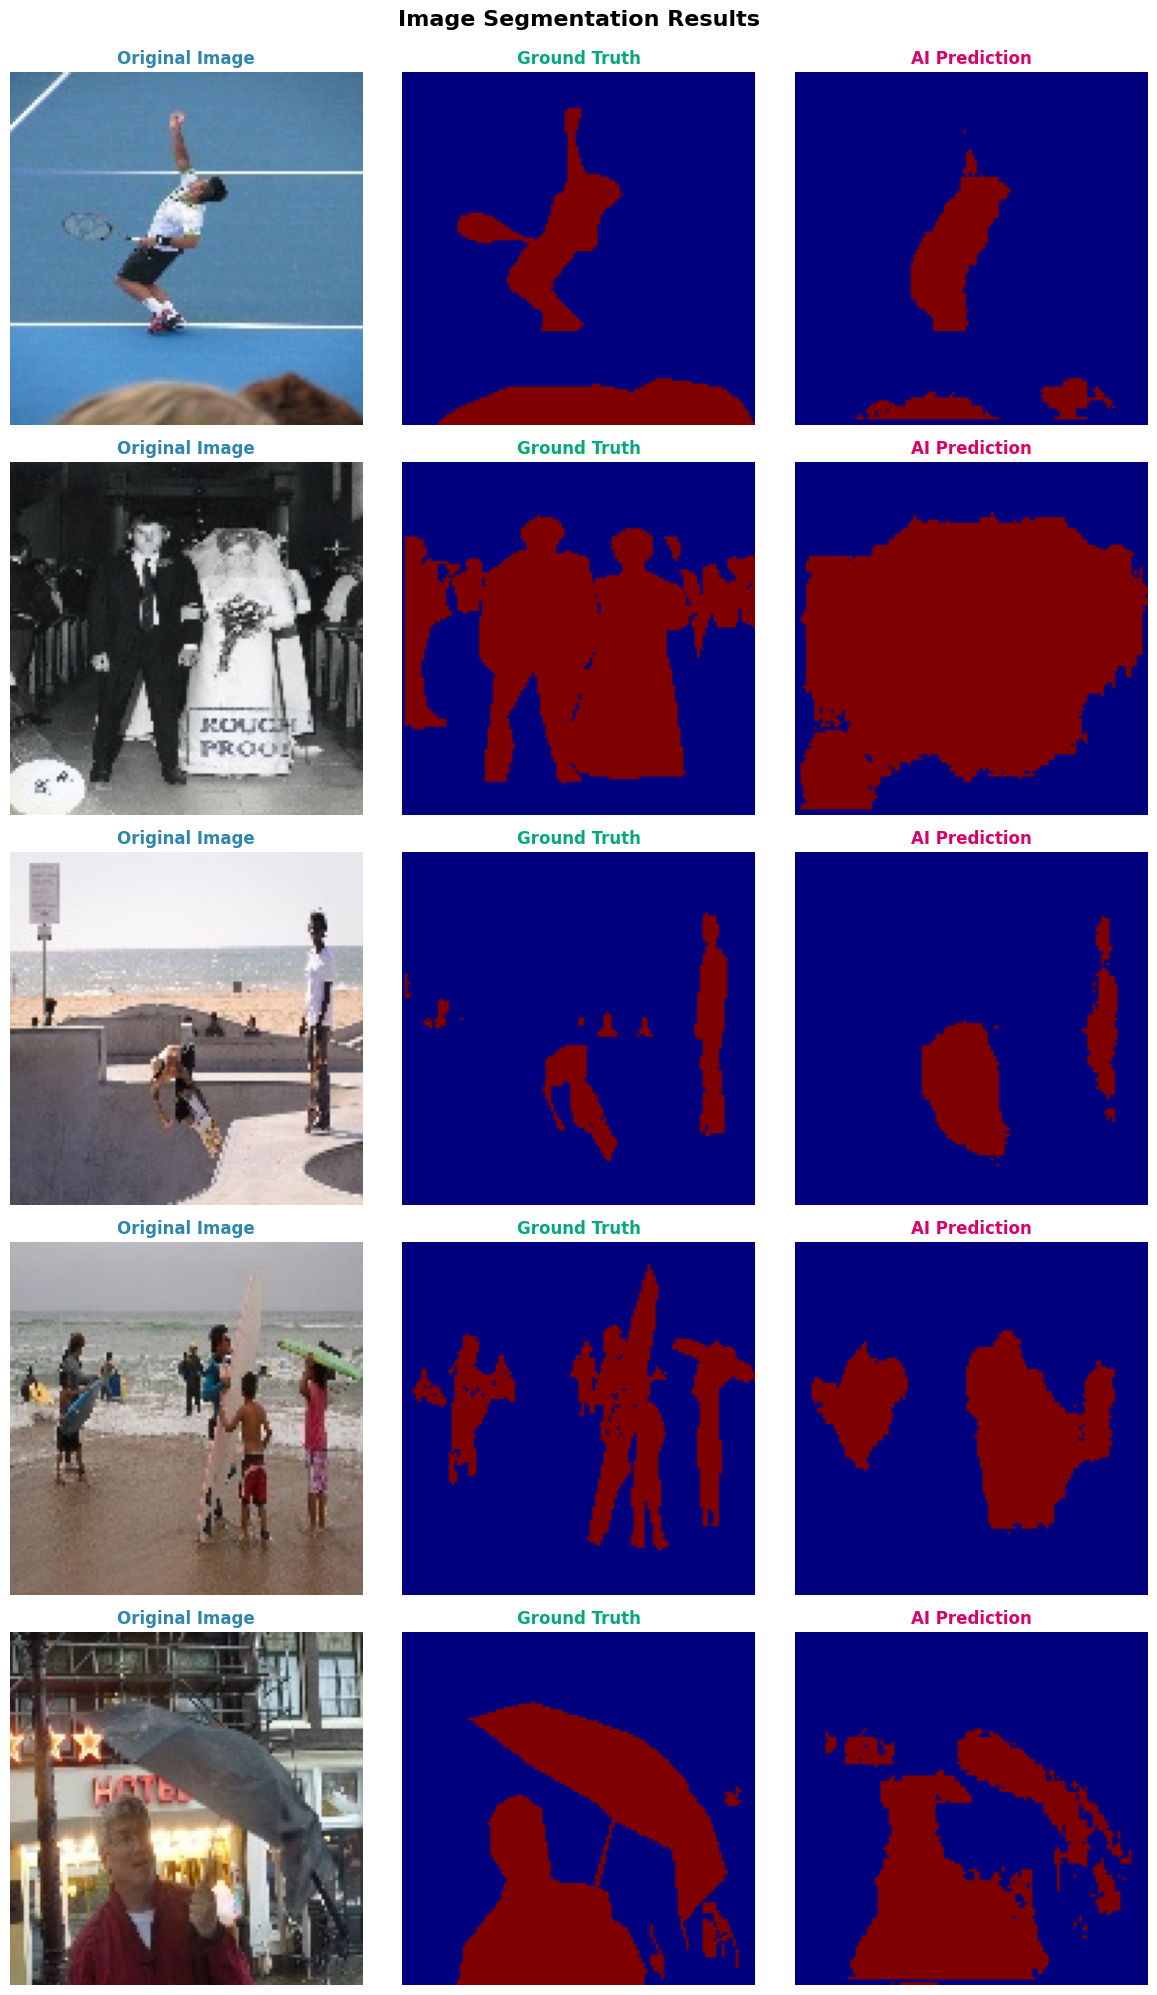

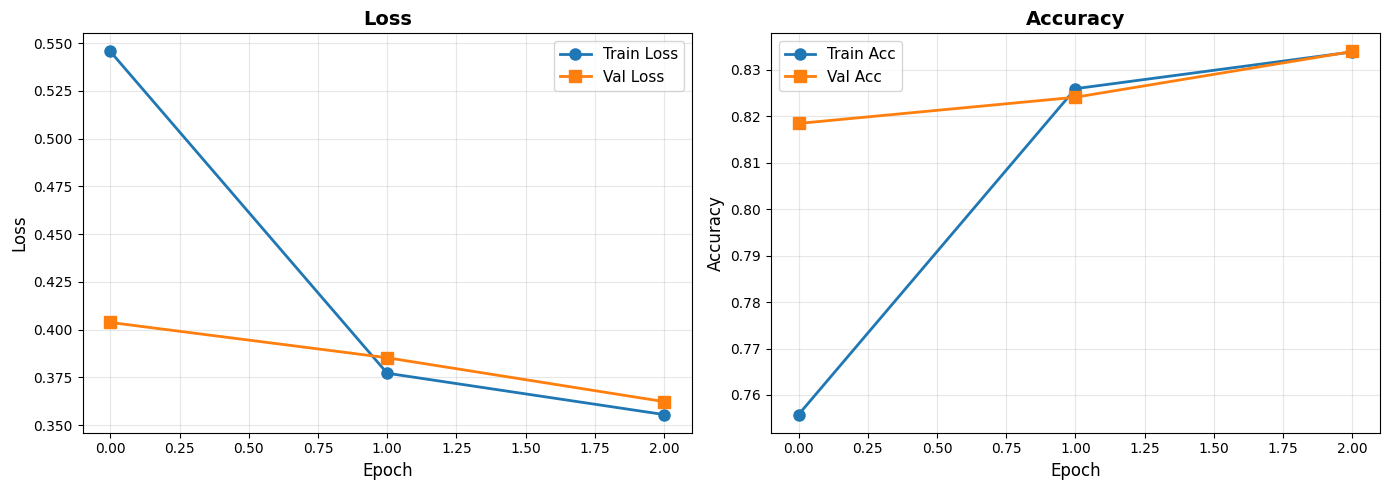


✅ ✅ ✅ COMPLETED SUCCESSFULLY! ✅ ✅ ✅

📊 Results:
   • Images processed: 1979
   • Training epochs: 3
   • Final train accuracy: 0.8339
   • Final val accuracy: 0.8340

📁 Files saved to: /content/drive/MyDrive/segmentation_results
   • best_model.keras
   • predictions.png
   • history.png


In [3]:
# ============================================================================
# FAST IMAGE SEGMENTATION - GOOGLE COLAB VERSION (FIXED)
# ============================================================================

# STEP 1: Mount Google Drive with error handling
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    SAVE_DIR = '/content/drive/MyDrive/segmentation_results'
    print("✅ Google Drive mounted successfully!")
except Exception as e:
    print(f"⚠️ Drive mount failed: {e}")
    print("📁 Saving to /content instead (temporary storage)")
    SAVE_DIR = '/content/results'

import os
os.makedirs(SAVE_DIR, exist_ok=True)

# STEP 2: Install required packages
!pip install pycocotools -q
!pip install opencv-python -q

# STEP 3: Download COCO 2017 dataset
print("\n📥 Downloading COCO 2017 dataset (this takes ~5-10 mins)...")
!wget -q http://images.cocodataset.org/zips/train2017.zip
!wget -q http://images.cocodataset.org/annotations/annotations_trainval2017.zip

print("📦 Extracting files...")
!unzip -q train2017.zip
!unzip -q annotations_trainval2017.zip

print("✅ Dataset ready!")

# ============================================================================
# IMPORTS
# ============================================================================

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from pycocotools.coco import COCO
from tqdm import tqdm
import cv2

print(f"\n✅ TensorFlow Version: {tf.__version__}")

# ============================================================================
# CONFIGURATION
# ============================================================================

dataDir = "/content"
dataType = "train2017"
imgdir_original = os.path.join(dataDir, dataType)
annFile = os.path.join(dataDir, "annotations", f"instances_{dataType}.json")

PROCESSED_DIR = "/content/processed"
IMG_DIR = os.path.join(PROCESSED_DIR, "images")
MASK_DIR = os.path.join(PROCESSED_DIR, "masks")
os.makedirs(IMG_DIR, exist_ok=True)
os.makedirs(MASK_DIR, exist_ok=True)

NUM_IMAGES = 2000
IMG_SIZE = 128
BATCH_SIZE = 16
EPOCHS = 3

# ============================================================================
# STEP 1: PREPROCESSING
# ============================================================================

print("\n" + "="*70)
print(f"PREPROCESSING {NUM_IMAGES} IMAGES")
print("="*70)

coco = COCO(annFile)
img_ids = coco.getImgIds()[:NUM_IMAGES]

saved = 0
for img_id in tqdm(img_ids, desc="Processing"):
    try:
        img_info = coco.loadImgs(img_id)[0]
        img_path = os.path.join(imgdir_original, img_info['file_name'])

        if not os.path.exists(img_path):
            continue

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ann_ids)

        mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)
        for ann in anns:
            m = coco.annToMask(ann)
            mask = np.logical_or(mask, m)

        mask = cv2.resize(mask.astype(np.uint8), (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)

        if mask.sum() < 10:
            continue

        name = img_info['file_name'].replace('.jpg', '')
        cv2.imwrite(f"{IMG_DIR}/{name}.jpg", cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
        cv2.imwrite(f"{MASK_DIR}/{name}.png", mask * 255)
        saved += 1
    except:
        continue

print(f"✅ Saved {saved} images")

# ============================================================================
# STEP 2: LOAD DATA
# ============================================================================

from tensorflow.keras.preprocessing.image import load_img, img_to_array

image_files = sorted(os.listdir(IMG_DIR))
print(f"\n✅ Found {len(image_files)} images")

def load_data():
    images, masks = [], []
    for f in tqdm(image_files, desc="Loading data"):
        img = load_img(f"{IMG_DIR}/{f}", target_size=(IMG_SIZE, IMG_SIZE))
        img = img_to_array(img) / 255.0

        mask = load_img(f"{MASK_DIR}/{f.replace('.jpg', '.png')}", target_size=(IMG_SIZE, IMG_SIZE), color_mode='grayscale')
        mask = img_to_array(mask) / 255.0

        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)

X, y = load_data()

split = int(0.8 * len(X))
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

print(f"✅ Train: {len(X_train)}, Val: {len(X_val)}")

# ============================================================================
# STEP 3: BUILD MODEL
# ============================================================================

print("\n" + "="*70)
print("BUILDING MOBILENET U-NET")
print("="*70)

from tensorflow.keras import layers, Model
from tensorflow.keras.applications import MobileNetV2

def build_unet():
    base = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
    base.trainable = False

    s1 = base.get_layer('block_1_expand_relu').output
    s2 = base.get_layer('block_3_expand_relu').output
    s3 = base.get_layer('block_6_expand_relu').output
    s4 = base.get_layer('block_13_expand_relu').output
    bridge = base.get_layer('block_16_project').output

    u1 = layers.UpSampling2D((2, 2))(bridge)
    u1 = layers.concatenate([u1, s4])
    c1 = layers.Conv2D(256, 3, activation='relu', padding='same')(u1)

    u2 = layers.UpSampling2D((2, 2))(c1)
    u2 = layers.concatenate([u2, s3])
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(u2)

    u3 = layers.UpSampling2D((2, 2))(c2)
    u3 = layers.concatenate([u3, s2])
    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(u3)

    u4 = layers.UpSampling2D((2, 2))(c3)
    u4 = layers.concatenate([u4, s1])
    c4 = layers.Conv2D(32, 3, activation='relu', padding='same')(u4)

    u5 = layers.UpSampling2D((2, 2))(c4)
    c5 = layers.Conv2D(16, 3, activation='relu', padding='same')(u5)

    output = layers.Conv2D(1, 1, activation='sigmoid')(c5)

    return Model(inputs=base.input, outputs=output)

model = build_unet()
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)])

print("✅ Model ready!")

# ============================================================================
# STEP 4: TRAIN
# ============================================================================

print("\n" + "="*70)
print(f"TRAINING - {EPOCHS} EPOCHS")
print("="*70 + "\n")

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

MODEL_PATH = f"{SAVE_DIR}/best_model.keras"

callbacks = [
    ModelCheckpoint(MODEL_PATH, monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, min_lr=1e-7)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

print("\n✅ Training complete!")

# ============================================================================
# STEP 5: VISUALIZE
# ============================================================================

print("\n" + "="*70)
print("GENERATING PREDICTIONS")
print("="*70 + "\n")

model.load_weights(MODEL_PATH)

fig, axes = plt.subplots(5, 3, figsize=(12, 20))

for i in range(5):
    idx = np.random.randint(0, len(X_val))
    img = X_val[idx]
    true_mask = y_val[idx]
    pred_mask = model.predict(np.expand_dims(img, 0), verbose=0)[0]
    pred_mask = (pred_mask > 0.5).astype(np.uint8)

    axes[i, 0].imshow(img)
    axes[i, 0].set_title('Original Image', fontsize=12, fontweight='bold', color='#2E86AB')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(true_mask.squeeze(), cmap='jet')
    axes[i, 1].set_title('Ground Truth', fontsize=12, fontweight='bold', color='#06A77D')
    axes[i, 1].axis('off')

    axes[i, 2].imshow(pred_mask.squeeze(), cmap='jet')
    axes[i, 2].set_title('AI Prediction', fontsize=12, fontweight='bold', color='#D90368')
    axes[i, 2].axis('off')

plt.suptitle('Image Segmentation Results', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(f'{SAVE_DIR}/predictions.png', dpi=150, bbox_inches='tight')
plt.show()

# Training history
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'o-', label='Train Loss', linewidth=2, markersize=8)
plt.plot(history.history['val_loss'], 's-', label='Val Loss', linewidth=2, markersize=8)
plt.legend(fontsize=11)
plt.title('Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'o-', label='Train Acc', linewidth=2, markersize=8)
plt.plot(history.history['val_accuracy'], 's-', label='Val Acc', linewidth=2, markersize=8)
plt.legend(fontsize=11)
plt.title('Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{SAVE_DIR}/history.png', dpi=150)
plt.show()

print("\n" + "="*70)
print("✅ ✅ ✅ COMPLETED SUCCESSFULLY! ✅ ✅ ✅")
print("="*70)
print(f"\n📊 Results:")
print(f"   • Images processed: {saved}")
print(f"   • Training epochs: {EPOCHS}")
print(f"   • Final train accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"   • Final val accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"\n📁 Files saved to: {SAVE_DIR}")
print(f"   • best_model.keras")
print(f"   • predictions.png")
print(f"   • history.png")
